In [43]:
# Alejandro Flores Hernández 1709458
# Marc Dalmau Guamis 1710713

import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    f1_score,
    make_scorer,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import time
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt

In [44]:
cotxes = "Cars_Data_6k.csv"
dftrain = pd.read_csv(cotxes)


In [45]:
#veiem que hi ha columnes amb -s que representen valors nuls
#les substituim per NaN
dftrain.replace("-", np.nan, inplace=True)

C:\Users\marcd\AppData\Local\Temp\ipykernel_8824\562233532.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dftrain.replace("-", np.nan, inplace=True)


In [46]:
# Mirem si hi ha nans a les dades de train

missing_percent_train = dftrain.isnull().mean() * 100

missing_percent_train = missing_percent_train.sort_values(ascending=False)

print("Percentatge de dades del train que falten per variable:\n")
print(missing_percent_train)
#treiem tank ja que esta buida sencera
dftrain = dftrain.drop(columns=["Tank"])



Percentatge de dades del train que falten per variable:

Tank            100.000000
Trunk            22.769128
Location         18.951950
Emissions        14.716223
Consumption       3.047045
Vmax              2.645237
0to100            0.435292
Sticker           0.418550
Weight            0.334840
Width             0.150678
Height            0.066968
KM                0.000000
Name              0.000000
Brand             0.000000
Unnamed: 0        0.000000
Year              0.000000
CV                0.000000
Fuel              0.000000
Length            0.000000
Transmission      0.000000
One_owner         0.000000
Keys_num          0.000000
Extras_num        0.000000
Price             0.000000
dtype: float64


In [47]:
# ============================
#  SPLIT ANTES DE IMPUTAR (OBLIGATORIO)
# ============================
from sklearn.model_selection import train_test_split

train_raw, test_raw = train_test_split(dftrain, test_size=0.2, random_state=42)


# =================================================
#  1) NUMÉRICAS CON POCOS NANS → MEDIA (SOLO TRAIN)
# =================================================
num_pocs_nans = ["Consumption", "Vmax", "0to100", "Weight", "Width", "Height"]

for col in num_pocs_nans:
    # media SOLO con train
    mean_val = train_raw[col].mean()
    train_raw[col].fillna(mean_val, inplace=True)
    test_raw[col].fillna(mean_val, inplace=True)   # aplicar misma media a test


# =================================================
#  2) CATEGÓRICAS CON POCOS NANS → MODA (SOLO TRAIN)
# =================================================
cat_pocs_nans = ["Sticker"]

for col in cat_pocs_nans:
    moda = train_raw[col].mode()[0]
    train_raw[col].fillna(moda, inplace=True)
    test_raw[col].fillna(moda, inplace=True)


# =============================
#  3) KNN IMPUTATION SIN LEAKAGE
# =============================
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
import numpy as np

cols_impute = ["Trunk", "Emissions", "Location"]

# --- LabelEncoder SOLO con train ---
le_loc = LabelEncoder()
train_raw["Location_enc"] = le_loc.fit_transform(train_raw["Location"].astype(str))
test_raw["Location_enc"]  = le_loc.transform(test_raw["Location"].astype(str))

cols_knn = ["Trunk", "Emissions", "Location_enc"]

# --- StandardScaler SOLO con train ---
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_raw[cols_knn])
test_scaled  = scaler.transform(test_raw[cols_knn])

# --- KNNImputer SOLO con train ---
imputer = KNNImputer(n_neighbors=5)
train_imputed_scaled = imputer.fit_transform(train_scaled)
test_imputed_scaled  = imputer.transform(test_scaled)

# --- desescalar ---
train_imputed = scaler.inverse_transform(train_imputed_scaled)
test_imputed  = scaler.inverse_transform(test_imputed_scaled)

# --- actualizar dataframes ---
train_raw[cols_knn] = train_imputed
test_raw[cols_knn]  = test_imputed

# --- convertir Location_enc de vuelta a texto ---
train_raw["Location_enc"] = train_raw["Location_enc"].round().astype(int)
test_raw["Location_enc"]  = test_raw["Location_enc"].round().astype(int)

train_raw["Location"] = le_loc.inverse_transform(train_raw["Location_enc"])
test_raw["Location"]  = le_loc.inverse_transform(test_raw["Location_enc"])

train_raw.drop(columns=["Location_enc"], inplace=True)
test_raw.drop(columns=["Location_enc"], inplace=True)


# ===========================
#  RESULTADOS LIMPIOS
# ===========================
dftrain = train_raw.copy()
dftest  = test_raw.copy()

print("NaNs train:\n", dftrain.isnull().sum())
print("\nNaNs test:\n", dftest.isnull().sum())


C:\Users\marcd\AppData\Local\Temp\ipykernel_8824\3886339637.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_raw[col].fillna(mean_val, inplace=True)
C:\Users\marcd\AppData\Local\Temp\ipykernel_8824\3886339637.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

NaNs train:
 Unnamed: 0      0
Brand           0
Name            0
Sticker         0
Year            0
KM              0
Fuel            0
CV              0
Transmission    0
One_owner       0
Location        0
Length          0
Width           0
Height          0
Weight          0
Trunk           0
Vmax            0
0to100          0
Consumption     0
Emissions       0
Keys_num        0
Extras_num      0
Price           0
dtype: int64

NaNs test:
 Unnamed: 0      0
Brand           0
Name            0
Sticker         0
Year            0
KM              0
Fuel            0
CV              0
Transmission    0
One_owner       0
Location        0
Length          0
Width           0
Height          0
Weight          0
Trunk           0
Vmax            0
0to100          0
Consumption     0
Emissions       0
Keys_num        0
Extras_num      0
Price           0
dtype: int64


In [48]:
# Miramos si hay NaNs SOLO en el TRAIN (sin fuga de datos)
missing_percent_train = dftrain.isnull().mean() * 100
missing_percent_train = missing_percent_train.sort_values(ascending=False)

print("Percentatge de dades del train que falten per variable:\n")
print(missing_percent_train)


Percentatge de dades del train que falten per variable:

Unnamed: 0      0.0
Brand           0.0
Name            0.0
Sticker         0.0
Year            0.0
KM              0.0
Fuel            0.0
CV              0.0
Transmission    0.0
One_owner       0.0
Location        0.0
Length          0.0
Width           0.0
Height          0.0
Weight          0.0
Trunk           0.0
Vmax            0.0
0to100          0.0
Consumption     0.0
Emissions       0.0
Keys_num        0.0
Extras_num      0.0
Price           0.0
dtype: float64


In [49]:
# ===========================
# Crear medias sin fuga (SOLO con train)
# ===========================

import pandas as pd

# --- Calcular medias SOLO con train_raw ---
brand_mean = train_raw.groupby("Brand")["Price"].mean()
brand_max  = train_raw.groupby("Brand")["Price"].max()
brand_min  = train_raw.groupby("Brand")["Price"].min()

model_mean = train_raw.groupby(["Brand", "Name"])["Price"].mean()
model_max  = train_raw.groupby(["Brand", "Name"])["Price"].max()
model_min  = train_raw.groupby(["Brand", "Name"])["Price"].min()

# ===========================
# Asignar a TRAIN (correcto)
# ===========================
train_raw["brand_mean_price"] = train_raw["Brand"].map(brand_mean)
train_raw["brand_max_price"]  = train_raw["Brand"].map(brand_max)
train_raw["brand_min_price"]  = train_raw["Brand"].map(brand_min)

train_raw["model_mean_price"] = train_raw.set_index(["Brand", "Name"]).index.map(model_mean)
train_raw["model_max_price"]  = train_raw.set_index(["Brand", "Name"]).index.map(model_max)
train_raw["model_min_price"]  = train_raw.set_index(["Brand", "Name"]).index.map(model_min)

# ===========================
# Asignar a TEST (sin fuga)
# ===========================
test_raw["brand_mean_price"] = test_raw["Brand"].map(brand_mean)
test_raw["brand_max_price"]  = test_raw["Brand"].map(brand_max)
test_raw["brand_min_price"]  = test_raw["Brand"].map(brand_min)

test_raw["model_mean_price"] = test_raw.set_index(["Brand", "Name"]).index.map(model_mean)
test_raw["model_max_price"]  = test_raw.set_index(["Brand", "Name"]).index.map(model_max)
test_raw["model_min_price"]  = test_raw.set_index(["Brand", "Name"]).index.map(model_min)

# ===========================
# Guardar de vuelta
# ===========================
dftrain = train_raw.copy()
dftest  = test_raw.copy()


In [50]:
# Variables categòriques a convertir en dummies
categorical_cols = ["Sticker", "Fuel", "Transmission", "Name", "Brand", "Location"]

# OHE només en el TRAIN (correcte)
dftrain = pd.get_dummies(dftrain, columns=categorical_cols, drop_first=True)

# Convertir booleans a enters (necessari per scikit-learn)
bool_cols = dftrain.select_dtypes(include='bool').columns
dftrain[bool_cols] = dftrain[bool_cols].astype(int)

# Comprovació
print(dftrain[bool_cols].head())


      One_owner  Sticker_B  Sticker_C  Sticker_ECO  Fuel_Eléctrico  Fuel_GLP  \
1881          0          0          1            0               0         0   
2835          0          0          1            0               0         0   
4095          0          0          1            0               0         0   
1173          0          0          1            0               0         0   
5749          0          1          0            0               0         0   

      Fuel_GNC  Fuel_Gasolina  Fuel_Híbrido  Fuel_Híbrido Enchufable  ...  \
1881         0              1             0                        0  ...   
2835         0              1             0                        0  ...   
4095         0              0             0                        0  ...   
1173         0              0             0                        0  ...   
5749         0              0             0                        0  ...   

      Location_Navarra  Location_Oviedo  Location_Pontev

In [51]:
# --- NORMALIZACIÓN SIN DATA LEAKAGE ---

from sklearn.preprocessing import StandardScaler

# Columnas a escalar
cols_to_scale = [
    "Year", "KM", "CV", "Length", "Width", "Height", "Weight", "Trunk",
    "Vmax", "0to100", "Consumption", "Emissions",
    "Keys_num", "Extras_num",
    "brand_mean_price", "brand_max_price", "brand_min_price",
    "model_mean_price", "model_max_price", "model_min_price"
]

# CREAMOS EL SCALER SOLO CON TRAIN
scaler = StandardScaler()
train_scaled_values = scaler.fit_transform(dftrain[cols_to_scale])
test_scaled_values  = scaler.transform(dftest[cols_to_scale])

# DATAFRAMES ESCALADOS
dftrain_scaled = pd.DataFrame(train_scaled_values, columns=cols_to_scale, index=dftrain.index)
dftest_scaled  = pd.DataFrame(test_scaled_values,  columns=cols_to_scale, index=dftest.index)

# RECONSTRUIMOS LOS DATASETS FINALES
dftrain_final = pd.concat([dftrain_scaled, dftrain[dftrain.columns.difference(cols_to_scale)]], axis=1)
dftest_final  = pd.concat([dftest_scaled,  dftest[dftest.columns.difference(cols_to_scale)]], axis=1)

# Comprobación
print(dftrain_final.head())


          Year        KM        CV    Length     Width    Height    Weight  \
1881  1.630761 -1.371545  0.028064 -0.338066  0.082393  0.245286 -0.366533   
2835 -0.553492 -0.202176 -0.900546 -0.981039 -1.132022 -0.632294 -1.176561   
4095  0.538634 -0.492907  1.163032  0.922162  0.269226 -0.687142  0.577801   
1173  0.811666 -0.878789 -0.652917  0.124875  0.456059  1.506806 -0.055952   
5749 -1.918649  1.400169  0.337601  0.021999  0.923142  0.409832  1.312283   

         Trunk      Vmax    0to100  ...  Name_Volvo XC40  Name_Volvo XC60  \
1881 -0.634053 -0.515618 -0.265660  ...                0                0   
2835 -1.104757 -0.368324 -0.117543  ...                0                0   
4095 -0.270772  2.381161 -0.258064  ...                0                0   
1173 -1.015237 -0.957500 -0.045383  ...                0                0   
5749  0.318908 -0.319226 -0.117543  ...                0                0   

      Name_XEV YOYO  One_owner  Price  Sticker_B  Sticker_C  Sticker

In [52]:
# Mirem si hi ha nans a les dades de train

missing_percent_train = dftrain.isnull().mean() * 100

missing_percent_train = missing_percent_train.sort_values(ascending=False)

print("Percentatge de dades del train que falten per variable:\n")
print(missing_percent_train)

Percentatge de dades del train que falten per variable:

Unnamed: 0           0.0
Year                 0.0
KM                   0.0
CV                   0.0
One_owner            0.0
                    ... 
Location_Toledo      0.0
Location_Valencia    0.0
Location_Vizcaya     0.0
Location_Zaragoza    0.0
Location_nan         0.0
Length: 367, dtype: float64


In [53]:
missing_percent_test = dftest.isnull().mean() * 100

missing_percent_test = missing_percent_test.sort_values(ascending=False)

print("Percentatge de dades del test que falten per variable:\n")
print(missing_percent_train)

Percentatge de dades del test que falten per variable:

Unnamed: 0           0.0
Year                 0.0
KM                   0.0
CV                   0.0
One_owner            0.0
                    ... 
Location_Toledo      0.0
Location_Valencia    0.0
Location_Vizcaya     0.0
Location_Zaragoza    0.0
Location_nan         0.0
Length: 367, dtype: float64


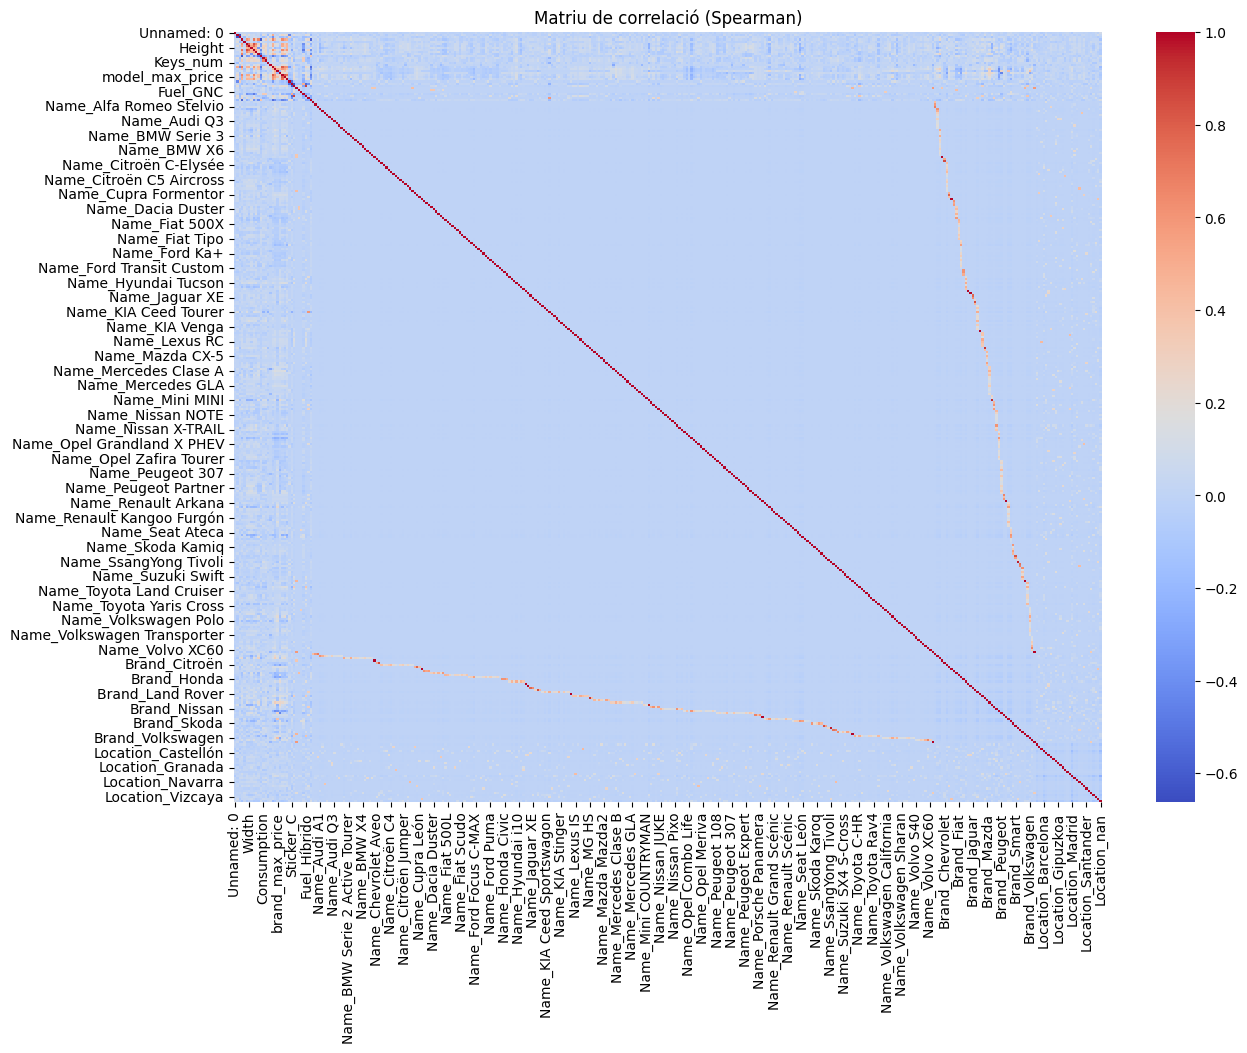

Price                  1.000000
model_mean_price       0.802299
CV                     0.684450
model_max_price        0.632546
model_min_price        0.607116
                         ...   
Brand_Opel            -0.216819
Sticker_B             -0.340509
KM                    -0.399539
0to100                -0.482902
Transmission_MANUAL   -0.531333
Name: Price, Length: 367, dtype: float64


In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlación Spearman (incluye solo numéricas automáticamente)
df_corr = dftrain.copy()   # <-- ESTE es tu df_final correcto ahora

corr_matrix = df_corr.corr(method="spearman")

plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Matriu de correlació (Spearman)")
plt.show()

# Variables ordenadas por correlación con Price
corr_with_price = corr_matrix["Price"].sort_values(ascending=False)
print(corr_with_price)


# HEM DE FER LA MATRIU DE CORRELACIÓ AMB LES VARIABLES INICIALS

In [55]:
# X e y SIN LEAKAGE
X_train = dftrain.drop(columns=["Price"])
y_train = dftrain["Price"]

X_test  = dftest.drop(columns=["Price"])
y_test  = dftest["Price"]


In [56]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
# === IMPORTS COMPLETOS PARA TODOS LOS MODELOS ===

# Modelos lineales
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge,
    SGDRegressor
)

# Árboles y modelos de ensamble
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)

# Vecinos
from sklearn.neighbors import KNeighborsRegressor

# Máquinas de soporte vectorial
from sklearn.svm import SVR

# Procesos Gaussianos
from sklearn.gaussian_process import GaussianProcessRegressor

# Partial Least Squares
from sklearn.cross_decomposition import PLSRegression

# Selección de características
from sklearn.feature_selection import SequentialFeatureSelector

# Validación cruzada
from sklearn.model_selection import KFold

# Otras utilidades
import pandas as pd
import numpy as np


# --- KFold para cross-validation ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- MODELOS ---
modelos_estimadores = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "BayesianRidge": BayesianRidge(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42, max_depth=5),
    "RandomForest": RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "SVR_linear": SVR(kernel="linear"),
    "SVR_rbf": SVR(kernel="rbf"),
    "DecisionTree_max_depth3": DecisionTreeRegressor(max_depth=3, random_state=42),
    "RandomForest_max_depth10": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    "GradientBoosting_lr05": GradientBoostingRegressor(learning_rate=0.05, n_estimators=50, max_depth=3, random_state=42),
    "ElasticNet_l1": ElasticNet(alpha=0.01, l1_ratio=1.0),
    "ElasticNet_l2": ElasticNet(alpha=0.01, l1_ratio=0.0),
    "SGDRegressor_huber": SGDRegressor(loss="huber", max_iter=1000, tol=1e-3, random_state=42)
}



In [57]:
# ...existing code...
# --- Construir modelos_columnas expandiendo dummies para categorías ---
# Base (mantenemos las listas originales, con las columnas categóricas como placeholders)
base_modelos_columnas = {
    "LinearRegression": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                         'Emissions', 'brand_mean_price', 'brand_min_price',
                         'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "Ridge": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
              'Emissions', 'brand_mean_price', 'brand_min_price',
              'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "Lasso": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
              'Emissions', 'brand_mean_price', 'brand_min_price',
              'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "ElasticNet": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                   'Emissions', 'brand_mean_price', 'brand_min_price',
                   'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "BayesianRidge": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                      'Emissions', 'brand_mean_price', 'brand_min_price',
                      'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "SGDRegressor": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                     'Emissions', 'brand_mean_price', 'brand_min_price',
                     'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "DecisionTree": ['Year', 'CV', 'Length', 'Height', '0to100', 'Consumption',
                     'Emissions', 'Keys_num', 'Extras_num',
                     'model_mean_price', 'model_max_price', 'model_min_price',
                     'Transmission'],

    "RandomForest": ['Year', 'KM', 'CV', 'Length', 'Height', 'Vmax', '0to100',
                     'Emissions', 'model_mean_price', 'model_max_price',
                     'model_min_price', 'Transmission', 'Location'],

    "GradientBoosting": ['Year', 'KM', 'CV', 'Width', 'Keys_num',
                         'brand_max_price', 'brand_min_price',
                         'model_mean_price', 'model_max_price',
                         'model_min_price', 'Brand', 'Transmission', 'Location'],

    "AdaBoost": ['Year', 'CV', 'Weight', 'Trunk', '0to100', 'Emissions',
                 'Keys_num', 'Extras_num', 'model_mean_price',
                 'Name', 'Fuel', 'One_owner', 'Location'],

    "KNeighbors": ['Year', 'KM', 'CV', 'Height', 'Weight', 'Trunk', 'Vmax',
                   'Consumption', 'Extras_num', 'model_mean_price',
                   'model_max_price', 'model_min_price', 'Transmission'],

    "SVR_linear": ['Year', 'KM', 'CV', 'Weight', 'Vmax', 'Emissions', 'Keys_num',
                   'brand_mean_price', 'model_mean_price',
                   'model_max_price', 'model_min_price', 'Sticker', 'Transmission'],

    "SVR_rbf": ['Year', 'KM', 'CV', 'Length', 'Width', 'Weight', 'Vmax',
                '0to100', 'model_mean_price', 'model_max_price',
                'model_min_price', 'Sticker', 'Transmission'],

    "DecisionTree_max_depth3": ['Year', 'Length', 'Width', 'Height', 'Weight',
                                'Trunk', 'Consumption', 'Keys_num', 'Extras_num',
                                'brand_mean_price', 'brand_max_price',
                                'brand_min_price', 'model_mean_price'],

    "RandomForest_max_depth10": ['Year', 'KM', 'CV', 'Length', 'Height', 'Weight',
                                 '0to100', 'Emissions', 'model_mean_price',
                                 'model_max_price', 'model_min_price',
                                 'Transmission', 'Location'],

    "GradientBoosting_lr05": ['Year', 'KM', 'CV', 'Consumption', 'Emissions',
                              'Keys_num', 'brand_max_price', 'model_mean_price',
                              'model_max_price', 'model_min_price', 'Brand',
                              'Transmission', 'Location'],

    "ElasticNet_l1": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                      'Emissions', 'brand_mean_price', 'brand_min_price',
                      'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "ElasticNet_l2": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                      'Emissions', 'brand_mean_price', 'brand_min_price',
                      'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "SGDRegressor_huber": ['Year', 'CV', 'Length', 'Weight', 'Vmax',
                           'brand_mean_price', 'model_mean_price',
                           'model_max_price', 'model_min_price', 'Brand',
                           'Sticker', 'Fuel', 'Location']
}

# Columnas categóricas originales (las que hiciste get_dummies)
categorical_placeholders = ["Sticker", "Fuel", "Transmission", "Name", "Brand", "Location", "One_owner"]

def expand_features(feature_list, df_cols, cat_placeholders):
    expanded = []
    seen = set()
    for feat in feature_list:
        # Si la columna existe tal cual (numérica o label-encoded), añadirla
        if feat in df_cols and feat not in seen:
            expanded.append(feat); seen.add(feat); continue

        # Si es una de las categorías, añadir todos los dummies que empiecen por "feat_"
        if feat in cat_placeholders:
            prefix = feat + "_"
            matches = [c for c in df_cols if c.startswith(prefix)]
            # si no hay matches, intentar contains (por si get_dummies formó nombres diferentes)
            if not matches:
                matches = [c for c in df_cols if feat in c]
            matches = [c for c in matches if c not in seen]
            expanded.extend(matches)
            seen.update(matches)
            continue

        # Si no es categórica, buscar columna exacta o columnas que contengan el nombre (fallback)
        matches = [c for c in df_cols if c == feat or c.endswith("_" + feat) or feat in c]
        for m in matches:
            if m not in seen:
                expanded.append(m); seen.add(m)
    return expanded

# Expande para cada modelo usando las columnas actuales de df_final
df_cols = list(dftrain.columns)  # df_final ya creado en el notebook
modelos_columnas = {}
for modelo, feats in base_modelos_columnas.items():
    modelos_columnas[modelo] = expand_features(feats, df_cols, categorical_placeholders)

# (Opcional) imprimir resumen rápido
for m, cols in modelos_columnas.items():
    print(f"{m}: {len(cols)} columnas")
# ...existing code...
print(modelos_columnas)

LinearRegression: 20 columnas
Ridge: 20 columnas
Lasso: 20 columnas
ElasticNet: 20 columnas
BayesianRidge: 20 columnas
SGDRegressor: 20 columnas
DecisionTree: 13 columnas
RandomForest: 40 columnas
GradientBoosting: 82 columnas
AdaBoost: 307 columnas
KNeighbors: 13 columnas
SVR_linear: 15 columnas
SVR_rbf: 15 columnas
DecisionTree_max_depth3: 13 columnas
RandomForest_max_depth10: 40 columnas
GradientBoosting_lr05: 82 columnas
ElasticNet_l1: 20 columnas
ElasticNet_l2: 20 columnas
SGDRegressor_huber: 89 columnas
{'LinearRegression': ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption', 'Emissions', 'brand_mean_price', 'brand_min_price', 'model_mean_price', 'Sticker_B', 'Sticker_C', 'Sticker_ECO', 'Fuel_Eléctrico', 'Fuel_GLP', 'Fuel_GNC', 'Fuel_Gasolina', 'Fuel_Híbrido', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL'], 'Ridge': ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption', 'Emissions', 'brand_mean_price', 'brand_min_price', 'model_mean_price', 'Sticker_B', 'Sticker_C', 'Sticker

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
from copy import deepcopy




# --- Cross-validation ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # negativo para que cross_val_score funcione

# --- Diccionario para almacenar los resultados ---
model_scores = {}

# --- Evaluar cada modelo con sus variables seleccionadas ---
for nombre_modelo, modelo in modelos_estimadores.items():
    features = modelos_columnas.get(nombre_modelo)
    
    if features is None or len(features) == 0:
        print(f"{nombre_modelo} no tiene variables seleccionadas, se omite.")
        model_scores[nombre_modelo] = None
        continue
    
    X_subset = X_train[[col for col in features if col in X_train.columns]]
    
    try:
        scores = cross_val_score(modelo, X_subset, y_train, cv=cv, scoring=mse_scorer, n_jobs=-1)
        mean_score = -np.mean(scores)  # convertir de negativo a positivo
        model_scores[nombre_modelo] = mean_score
        print(f"{nombre_modelo} - MSE promedio: {mean_score:.4f}")
    
    except Exception as e:
        print(f"Error evaluando {nombre_modelo}: {e}")
        model_scores[nombre_modelo] = None

# --- Elegir el mejor modelo ---
best_model = min((mse, mdl) for mdl, mse in model_scores.items() if mse is not None)
print(f"\nMejor modelo: {best_model[1]} con MSE = {best_model[0]:.4f}")
# Mostrar MSE CV (ya en model_scores) y MSE en test para cada modelo

model_test_scores = {}
print("\nComparativa CV vs Test MSE:")
for nombre_modelo, modelo in modelos_estimadores.items():
    cv_mse = model_scores.get(nombre_modelo)
    feats = modelos_columnas.get(nombre_modelo)
    if cv_mse is None or not feats:
        print(f"{nombre_modelo}: CV MSE = {cv_mse} -> omitido (sin features o error CV).")
        continue

    cols = [c for c in feats if c in X_train.columns]
    if len(cols) == 0:
        print(f"{nombre_modelo}: no hay columnas válidas en train/test, omito test.")
        continue

    try:
        m = deepcopy(modelo)
        m.fit(X_train[cols], y_train)
        y_pred = m.predict(X_test[cols])
        test_mse = mean_squared_error(y_test, y_pred)
        model_test_scores[nombre_modelo] = test_mse

        ratio = test_mse / cv_mse if cv_mse > 0 else np.inf
        flag = ""


        print(f"{nombre_modelo}: CV MSE = {cv_mse:.2f} | Test MSE = {test_mse:.2f} | ratio={ratio:.2f}{flag}")

    except Exception as e:
        print(f"{nombre_modelo}: error calculando Test MSE: {e}")


LinearRegression - MSE promedio: 8483593.2858
Ridge - MSE promedio: 8476187.7349
Lasso - MSE promedio: 8483419.7535
ElasticNet - MSE promedio: 8636790.3904
BayesianRidge - MSE promedio: 8478594.0748
SGDRegressor - MSE promedio: 9009724637657016628104787980655263744.0000
DecisionTree - MSE promedio: 11214056.0062
RandomForest - MSE promedio: 7892292.7966
GradientBoosting - MSE promedio: 4858076.5070
AdaBoost - MSE promedio: 11647996.3040
KNeighbors - MSE promedio: 5799434.6758


KeyboardInterrupt: 

In [ ]:
# ...existing code...
# --- Elegir el mejor modelo ---
best_model = min((mse, mdl) for mdl, mse in model_scores.items() if mse is not None)
print(f"\nMejor modelo: {best_model[1]} con MSE = {best_model[0]:.4f}")

# --- BÚSQUEDA DE HIPERPARÁMETROS con GridSearchCV para RandomForest_max_depth10 ---
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Reusar CV y scoring
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = "neg_mean_squared_error"

target_name = "RandomForest_max_depth10"
features_rf = [c for c in modelos_columnas.get(target_name, []) if c in X_train.columns]
print(features_rf)

rf = RandomForestRegressor(random_state=42)

# Grid reducido (ampliar si dispone de tiempo/cómputo)
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15, None],
    "max_features": ["sqrt", "log2", 0.5],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True, False]
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

print(f"\nIniciando GridSearchCV para {target_name} sobre {len(features_rf)} features...")
grid.fit(X_train[features_rf], y_train)

best_params = grid.best_params_
best_cv_neg_mse = grid.best_score_
best_cv_mse = -best_cv_neg_mse

print(f"\nMejores hiperparámetros (CV): {best_params}")
print(f"MSE CV promedio (positivo): {best_cv_mse:.4f}")

# Evaluar en test set
best_rf = grid.best_estimator_
y_pred_test = best_rf.predict(X_test[features_rf])
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"MSE en test set: {mse_test:.4f}")

# Guardar estimador optimizado
modelos_estimadores[target_name] = best_rf
model_scores[target_name] = mse_test

print(f"\nRandomForest optimizado guardado en modelos_estimadores['{target_name}'].")
# ...existing code...

In [ ]:
#Mejores hiperparámetros (CV): {'bootstrap': False, 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
